<a href="https://colab.research.google.com/github/yokahealthcare/Anasa-GAN/blob/master/%5BMain%20v2%5D%20%5BAE%5D%20%5BANN%5D%20%5BAutoKeras%5D%20Breathing_Wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AE - AutoEncoder

## Project Strucuture

### PART 1 : Data Preprocessing


1.   Filter the zeros values (except if in the first column)
2.   Separate the data(q) according to labels
3.   Seperate q into data(X) and label(Y)
4.   Normalize the data
> X normalized using MinMaxScaler between 0 and 1
>
> Y normalized using one-hot encoding

### PART 2 : Neural Network
1.   NN Structure
2.   Optimizer : Adam(learning_rate=0.0001)
3.   Loss      : MAE (Mean Average Error)

### PART 3 : Training
1.   Training
2.   Smoothing using Savitzky-Golay filter


# PART 1 : Data Preprocessing

In [8]:
!pip install autokeras

### Importing Libraries

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

### Download the dataset

In [10]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  print('Downloding the data through internet...')
  df = pd.read_csv("https://raw.githubusercontent.com/yokahealthcare/Anasa-GAN/master/dataset/breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")
else:
  print('Not running on CoLab')
  print('Use the dataset from folder')
  df = pd.read_csv("dataset/breathing_waveform_data.csv").iloc[:, :-1] # get rid of last column ("notes")


Running on CoLab
Downloding the data through internet...


### Filter the zeros values
> This will filtered the zeros value from all column (except first column)
>
> CAUSE : I think is natural for the first column to be 0.0 (because the time(X) still on 0 second)

In [11]:
zeros_val = df[df.iloc[:, 1:].eq(0).any(axis=1)]

### Drop the table that has value zeros on it

In [12]:
df = df[~df.isin(zeros_val)].dropna()

In [13]:
df['labels'].value_counts()

normal        19060
quick          2667
hold           2133
deep           1066
deep_quick      800
Name: labels, dtype: int64

### Normalize the data

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def preprocessor(X, x_type="MinMaxScaler"):
  std_scaler = StandardScaler().fit(X)
  min_max_scaler = MinMaxScaler().fit(X)

  if x_type == "StandardScaler":
    return std_scaler.transform(X)
  elif x_type == "MinMaxScaler":
    return min_max_scaler.transform(X)

### Importing Neural Network Libraries

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Activation

from keras.optimizers import Adamax
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

# PART 4 : Testing the Model

### Define a function to smoothing the wave curve

In [4]:
# smoothing the wave of decoded_data
from scipy.signal import savgol_filter

def smooth_wave(wave):
  # Define the parameters for the Savitzky-Golay filter
  window_length = 10  # The length of the window (odd number)
  polyorder = 2  # The order of the polynomial fit

  return savgol_filter(wave, window_length, polyorder)

### Define a function to plot the result

In [5]:
def plot_graph(tran_X, reconstructed, loss, num_samples=20):
  row = int(num_samples / 5)

  # Create figure and axis objects
  fig, ax = plt.subplots(row, 5, figsize=(20,row*3))

  idx=0
  for y in range(row):
    for x in range(5):
      # Plot each time series
      ax[y, x].plot(tran_X[idx], 'b')
      ax[y, x].plot(reconstructed[idx], 'g')
      ax[y, x].fill_between(np.arange(X.shape[1]), reconstructed[idx], tran_X[idx], color='lightcoral')
      ax[y, x].set_title("Data {}; err : {:.2f}%".format(idx, loss[idx]*100))
      #ax[y, x].legend()

      idx += 1

  # legend
  plt.legend(labels=["Input", "Reconstruction", "Error"], loc='center left', bbox_to_anchor=(1, 0.5))

  # Customize the overall layout
  plt.tight_layout()

  # Show
  plt.show()

### Testing the model

In [11]:
def test_model(tran_X, main_model):
  # encode & decode the wave
  decoded = main_model.predict(tran_X)

  # Apply the Savitzky-Golay filter (smoothing the wave)
  decoded_smoothed = smooth_wave(decoded)

  # Calculate the Mean Average Error (MAE)
  loss_actual = tf.keras.losses.mae(decoded, tran_X)
  loss_smoothed = tf.keras.losses.mae(decoded_smoothed, tran_X)
  print("[actual] Mean Average Error : {}%".format(np.mean(loss_actual * 100)))
  print("[smoothed] Mean Average Error : {}%".format(np.mean(loss_smoothed * 100)))

  # plot the reconstructed data vs actual data
  plot_graph(tran_X, decoded_smoothed, loss_smoothed, num_samples=25)

# PART 5 : ALL IN ONE BUTTON

In [12]:
# Autokeras - AUTOML
from autokeras import StructuredDataRegressor

In [13]:
def run_all(X):
  # Preprocessed the data
  tran_X = preprocessor(X, x_type="MinMaxScaler")

  # define the search
  search = StructuredDataRegressor(max_trials=15, loss='mean_absolute_error')
  # perform the search
  search.fit(x=tran_X, y=tran_X, verbose=1, epochs=30)

  # get the best performing model
  main_model = search.export_model()
  # summarize the loaded model
  main_model.summary()

  # evaluate the model
  mae, _ = search.evaluate(tran_X, tran_X, verbose=0)
  print('MAE: %.3f' % mae)

  # Testing the model
  test_model(tran_X, main_model)

  # save the model to file
  main_model.save("autokeras_regression_best_model.h5")

  return main_model


# PART 6 : RUNNING THE CODE

### Separate the data according to their labels

In [15]:
normal_df = df[df['labels'] == "normal"]
quick_df = df[df['labels'] == "quick"]
hold_df = df[df['labels'] == "hold"]
deep_df = df[df['labels'] == "deep"]
deep_quick_df = df[df['labels'] == "deep_quick"]

### Seperate the data (X)
> we don't need Y (label) because we already seperate the dataset according to their label each one
>
> **"normal"** (19060), **"quick"** (2667), **"hold"** (2133), **"deep"** (1066), **"deep_quick"** (800)

In [17]:
# Seperate the X only
X = normal_df.iloc[:, :-1]
X_train = X.iloc[:int(X.shape[0]*0.8), :]
X_test = X.iloc[int(X.shape[0]*0.8):, :]

print(f"X_train : {X_train.shape}")
print(f"X_test : {X_test.shape}")

# Running All in One (training & testing & saving model file)
#main_model = run_all(X_train)

X_train : (15248, 85)
X_test : (3812, 85)


# PART 7 : Generating New Data

### Define a function to plotting the generated data result

In [16]:
def plot_graph_generated(generated_data, num_samples=10, title="You can write the title"):
  # Create figure and axis objects
  row = int(num_samples / 5)

  fig, ax = plt.subplots(row, 5, figsize=(20,row*3))

  idx=0
  for y in range(row):
    for x in range(5):
      # Plot each time series
      ax[y, x].plot(generated_data[idx], 'b')
      ax[y, x].set_title("Data {}".format(idx))

      idx += 1

  # legend
  plt.legend(labels=["Generated"], loc='center left', bbox_to_anchor=(1, 0.5))

  # title
  plt.suptitle(title)

  # Customize the overall layout
  plt.tight_layout()

  # Show
  plt.show()

### Setting up parameters

In [17]:
# Set the number of data points to generate
generated_samples = 10
# Randomly sample latent vectors from a predefined range
noise_vectors = np.random.rand(*(generated_samples, 85))
# Generate new data by decoding the latent vectors
generated_data = main_model.predict(noise_vectors)

1/1 [==============================] - 0s 30ms/step


In [18]:
main_model.evaluate(X_test, X_test)

120/120 [==============================] - 0s 2ms/step - loss: 0.1756 - mean_squared_error: 0.0612


[0.1755695343017578, 0.06123454123735428]

In [2]:
from keras.models import load_model
import autokeras as ak

main_model = load_model("/content/autokeras_regression_best_model.h5", custom_objects=ak.CUSTOM_OBJECTS)

In [18]:
# Preprocessed the data
X_test = preprocessor(X_test, x_type="MinMaxScaler")
decoded = main_model.predict(X_test)

120/120 [==============================] - 1s 3ms/step


[actual] Mean Average Error : 1.1860637290987897%
[smoothed] Mean Average Error : 1.2320797123600322%


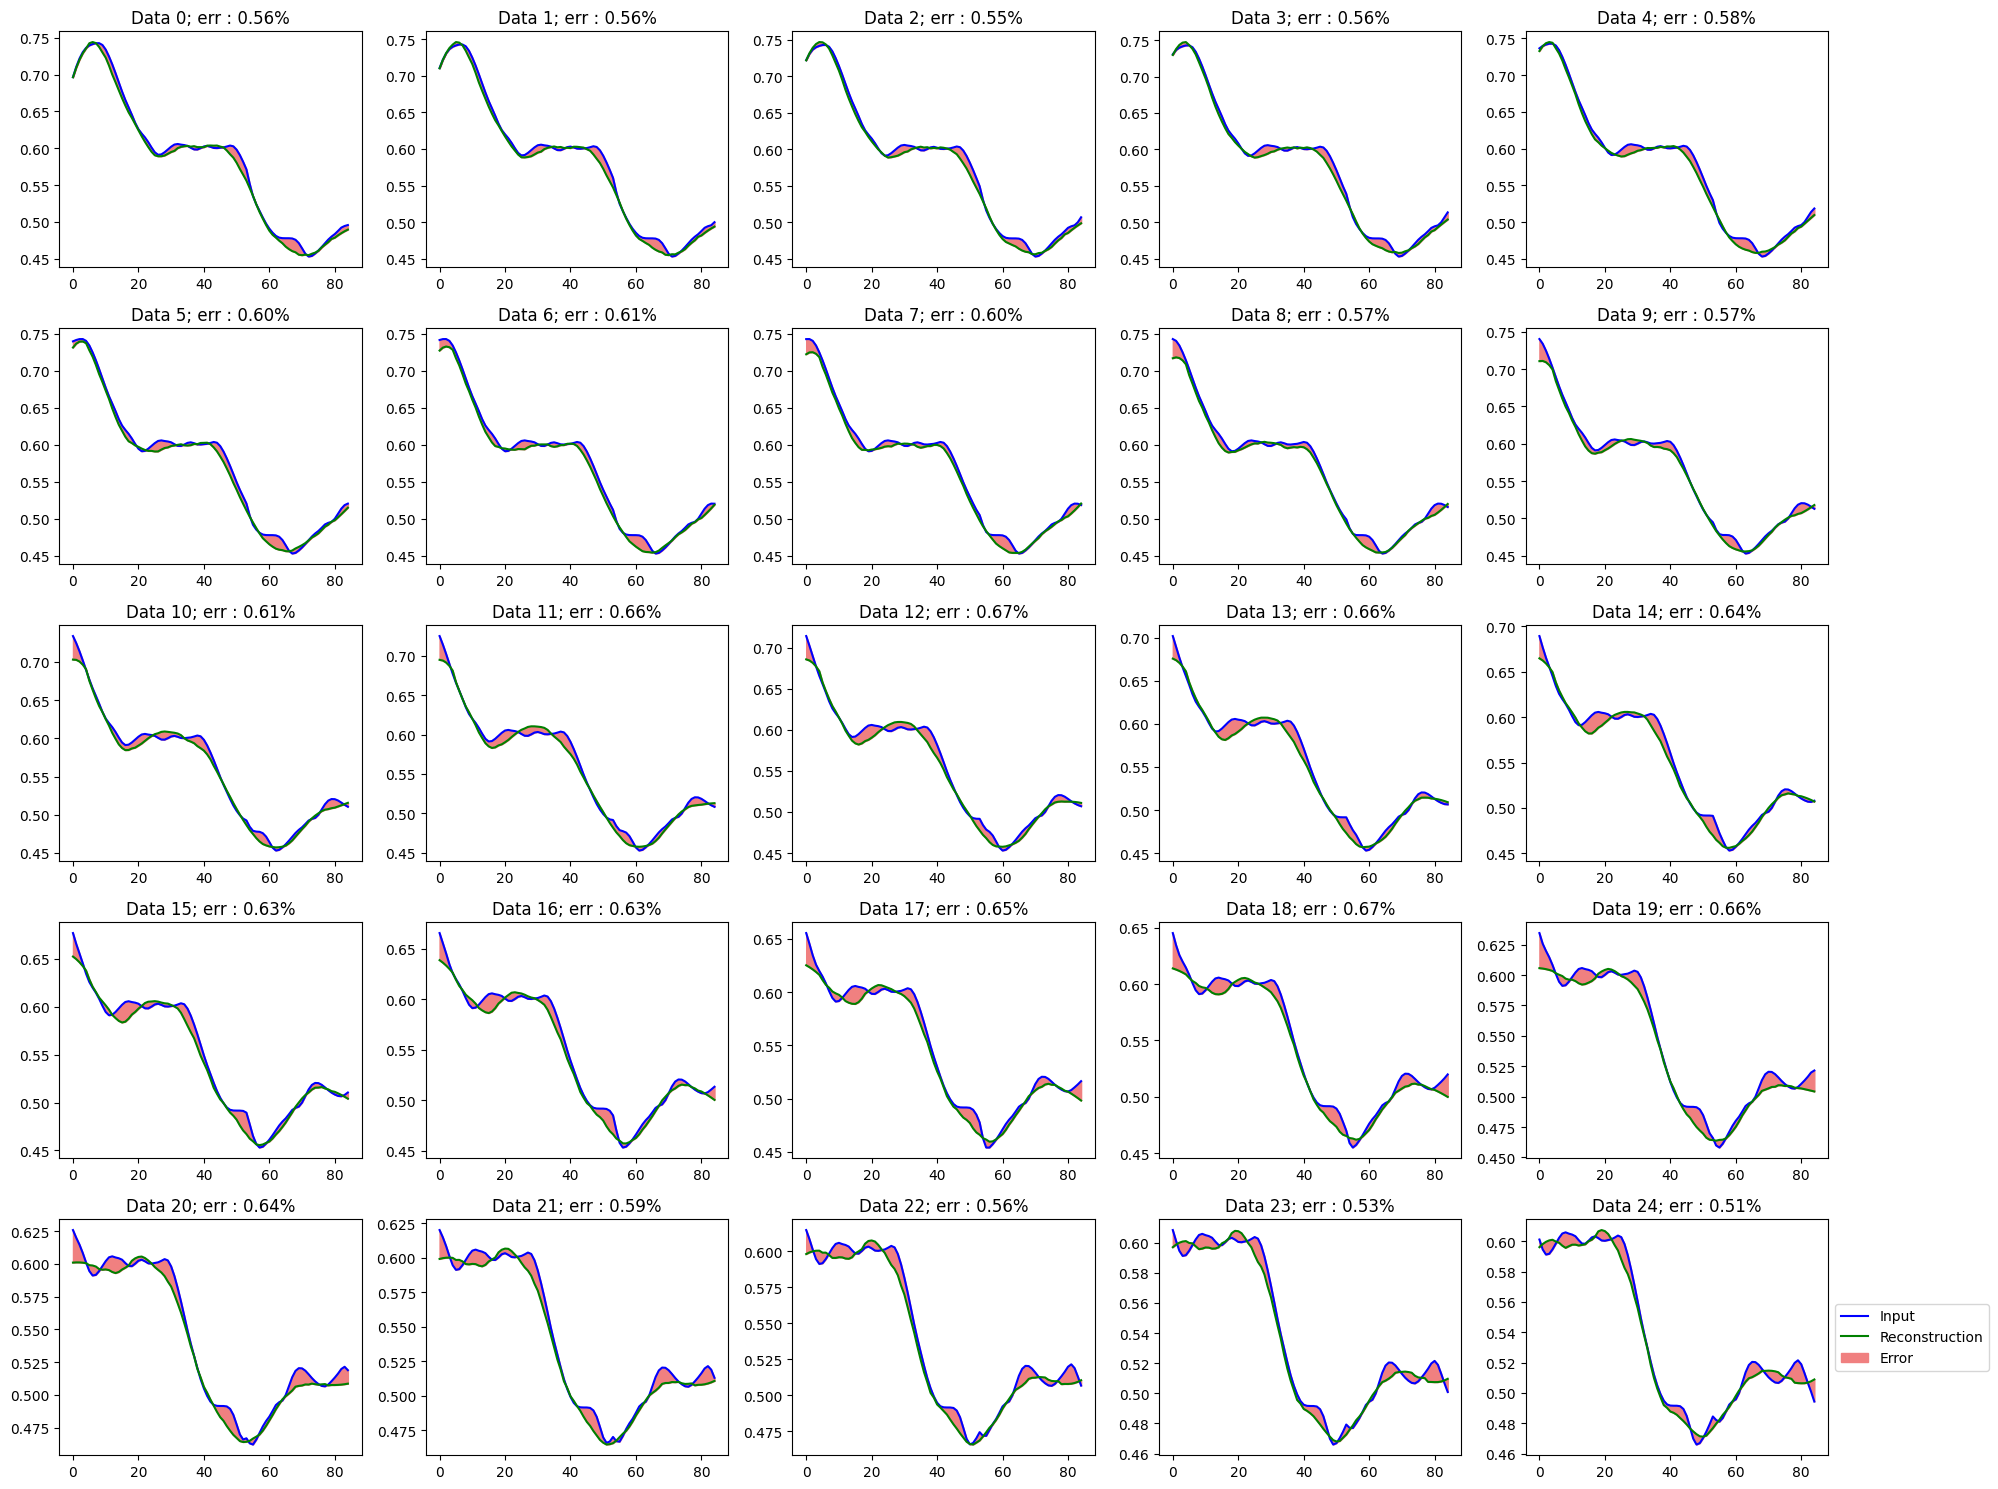

In [19]:
# Apply the Savitzky-Golay filter (smoothing the wave)
decoded_smoothed = smooth_wave(decoded)

# Calculate the Mean Average Error (MAE)
loss_actual = tf.keras.losses.mae(decoded, X_test)
loss_smoothed = tf.keras.losses.mae(decoded_smoothed, X_test)
print("[actual] Mean Average Error : {}%".format(np.mean(loss_actual * 100)))
print("[smoothed] Mean Average Error : {}%".format(np.mean(loss_smoothed * 100)))

# plot the reconstructed data vs actual data
plot_graph(X_test, decoded_smoothed, loss_smoothed, num_samples=25)

### Plot the generated data before & after smoothing process

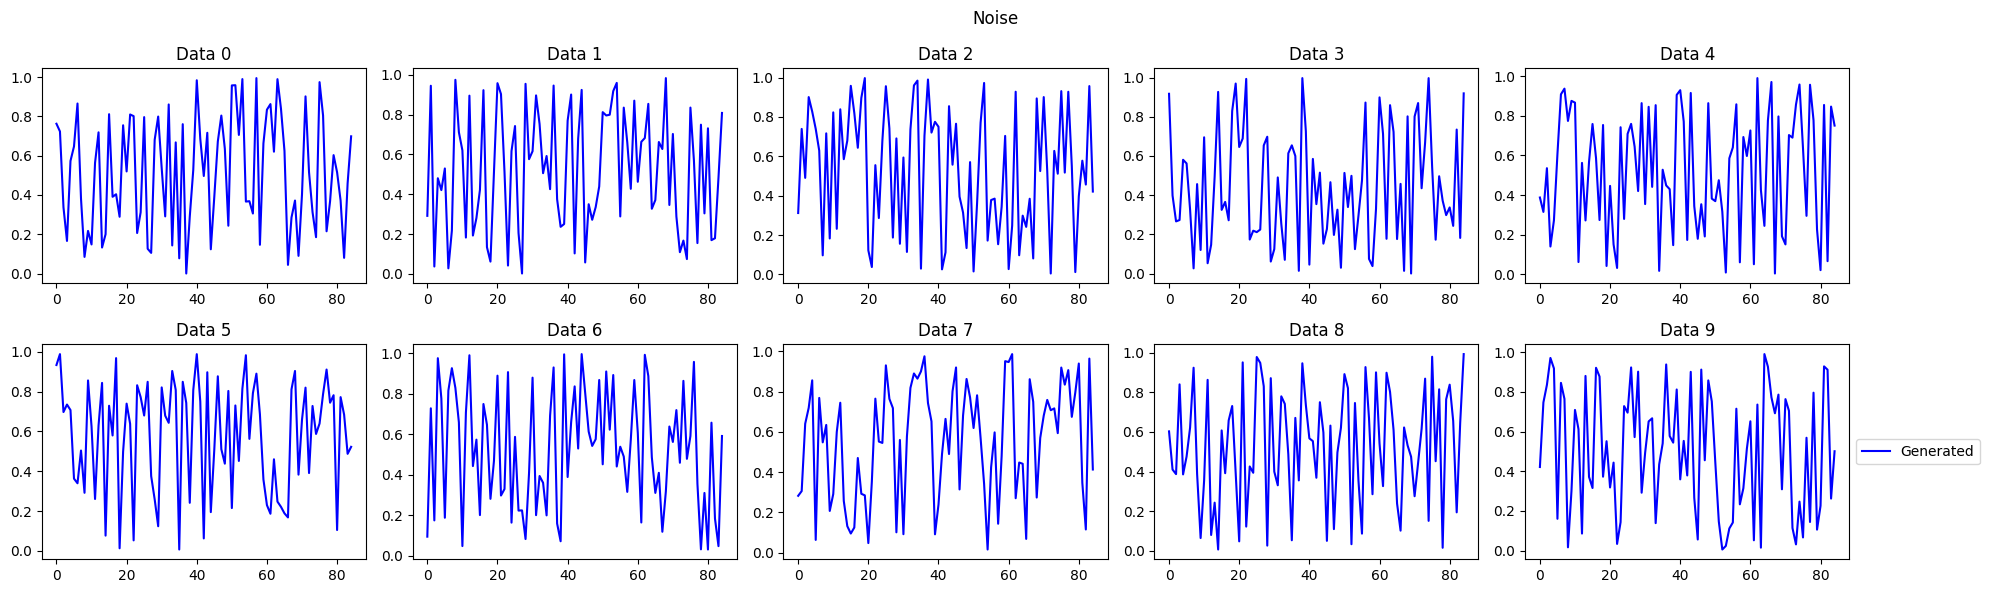

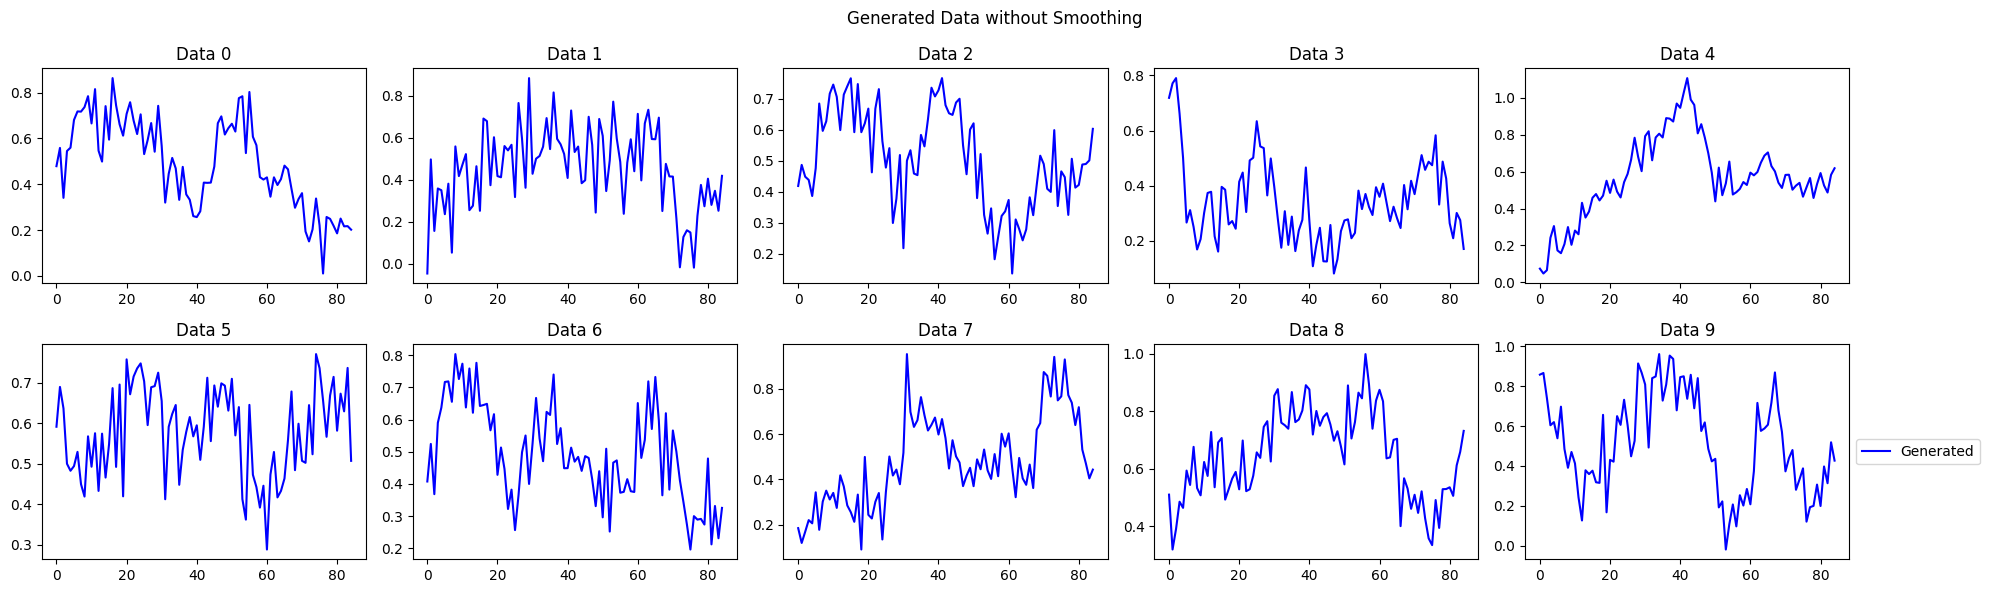

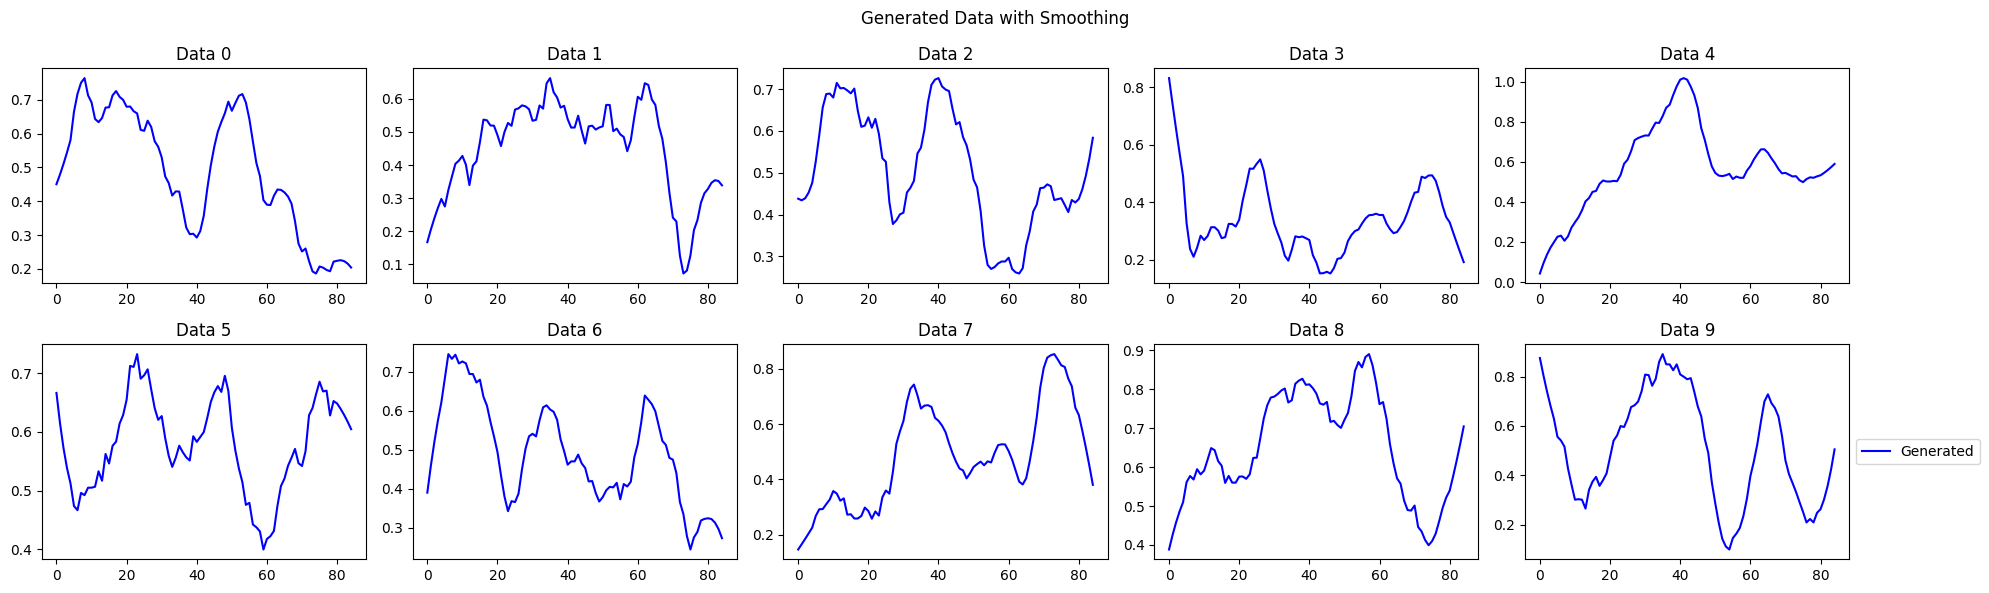

In [20]:
# Plot the graph before smoothing process
plot_graph_generated(noise_vectors, num_samples=generated_samples, title="Noise")
# Plot the graph before smoothing process
plot_graph_generated(generated_data, num_samples=generated_samples, title="Generated Data without Smoothing")

# Apply the Savitzky-Golay filter
generated_data_smoothed = smooth_wave(generated_data)

# Plot the graph after smoothing process
plot_graph_generated(generated_data_smoothed, num_samples=generated_samples, title="Generated Data with Smoothing")